In [ ]:
import csv
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalMaxPooling2D, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import KFold, StratifiedKFold
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [ ]:
class Imgae_utils:

    def gamma_trans(self, img, gamma):
        gamma_table = [np.power(x / 255.0, gamma) * 255.0 for x in range(256)]
        gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
        return cv.LUT(img, gamma_table)

    def linear_hist_transform(self, img, persent=0.05):
        a = 0
        b = 255
        res_img = np.copy(img)
        array = np.sort(res_img.flat)
        count_del = int(len(array) * persent / 2)
        y_min = array[count_del - 1]
        y_max = array[-count_del]

        for i in range(res_img.shape[0]):
            for j in range(res_img.shape[1]):
                if (res_img[i][j] > y_max):
                    res_img[i][j] = 255
                elif (res_img[i][j] < y_min):
                    res_img[i][j] = 0
                else:
                    res_img[i][j] = int((b - a) * (res_img[i][j] - y_min) / (y_max - y_min))

        return res_img

    def variance_of_laplacian(self, image):
        return cv.Laplacian(image, cv.CV_64F).var()

    def best_candidate(self, candidates):
      score = 0
      for candidate in candidates:
        temp_score = candidate[1] + candidate[2]
        if temp_score > score:
          score = temp_score
          best_candidate = candidate[0]
      return best_candidate

    def test_cut(self, image):
      candidates = []
      imag = np.copy(image)
      x1_max, y1_max, box_length_max = 0, 0, 0
      corners_count = 0
      best_rating = 0
      mean_global_white = np.mean(imag)
      im = np.float32(cv.medianBlur(imag,11))
      dst = cv.cornerHarris(im,2,3,0.04)
      corners = dst>0.0001*dst.max()
      l = 150
      for i in range(0, imag.shape[0] - l, 50):
        for j in range(0, imag.shape[1] - l, 50):
          x1, y1 = i, j
          x2, y2 = x1 + l, y1 + l
          sum_corners = len(imag[x1 : x2, y1 : y2][corners[x1 : x2, y1 : y2]])/(l**2)*10000
          focus = self.variance_of_laplacian(imag[x1 : x2, y1 : y2])
          if(sum_corners > corners_count):
            #if(sum_corners + focus > best_rating):
            x1_max, y1_max, box_length_max = x1, y1, l
            corners_count = sum_corners
            focus_max = focus
            candidates.append([imag[x1_max : x1_max+ box_length_max, y1_max : y1_max + box_length_max], corners_count, focus_max])

      result_img = self.best_candidate(candidates)
      # fig = plt.figure(figsize=(5, 5))
      # plt.imshow(result_img, cmap='gray')
      # plt.title("Image cut")
      # plt.show()

      return result_img

#0-50: 0 класс;
#51-100: 1 класс;
#101-150: 2 класс;
#151 и больше: 3 класс;


In [ ]:
def load_data(breathability_path):
    paths = []
    breathability = []

    with open(breathability_path, encoding="utf-8") as file:
        reader = csv.reader(file, delimiter=',')
        for r in reader:
            paths.append(r[0])
            breth = float(r[1])
            if(breth<=50):
              breathability.append(0)
            elif(50 < breth <= 100):
              breathability.append(1)
            elif(100 < breth <= 150):
              breathability.append(2)
            else:
              breathability.append(3)
    return paths, breathability

def processing_image(path):
    img = Image.open('/content/drive/MyDrive/Photos_TS/' + path)
    img = np.array(img.resize((600, 600)))
    gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    gray_img = util.test_cut(gray_img)
    white = np.mean(gray_img)
    if white <= 55:
        n = 0.01
    elif 55 < white <= 85:
        n = 0.05
    elif 85 < white <= 150:
        n = 0.10
    else:
        n = 0.15
    gray_img = util.linear_hist_transform(gray_img, n)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    gray_img = cv.filter2D(gray_img, -1, kernel)
    im3 = gray_img / 255
    return im3

def processing_images(paths):
    processed_images = []
    for path in paths:
        processed_images.append(processing_image(path))
        #np.expand_dims(processed_images, axis=-1)
    return processed_images

        # fig = plt.figure(figsize=(5, 5))
        # plt.imshow(im, cmap="gray")
        # plt.show()

In [ ]:
if __name__ == '__main__':
    util = Imgae_utils()
    paths, breathability = load_data('breath.txt')
    processed_images = processing_images(paths)
    np.save("images_class.npy", processed_images)
    np.save("breathability_class", breathability)

In [ ]:
with open("images_class.npy", "rb") as im:
  c_images = np.load(im)
with open("breathability_class.npy", "rb") as br:
  c_breathability = np.load(br)
c_images = c_images.reshape(-1,150,150,1)
img_train, img_test, br_train, br_test = train_test_split(c_images, to_categorical(c_breathability), train_size=0.8)

In [ ]:
df = pd.DataFrame(br_train)


In [ ]:
def model():
    breathability_model = tf.keras.models.Sequential()

    breathability_model.add(Conv2D(32, kernel_size=3, padding="same", activation='relu', input_shape=(150, 150, 1), kernel_regularizer=keras.regularizers.l2(0.001)))
    breathability_model.add(MaxPooling2D((2, 2), strides=2))
    breathability_model.add(BatchNormalization())

    breathability_model.add(Conv2D(64, kernel_size=3, padding="same", activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    breathability_model.add(MaxPooling2D((2, 2), strides=2))
    breathability_model.add(BatchNormalization())

    breathability_model.add(Conv2D(128, kernel_size=3, padding="same", activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    breathability_model.add(MaxPooling2D((2, 2), strides=2))
    breathability_model.add(BatchNormalization())

    breathability_model.add(GlobalMaxPooling2D())
    breathability_model.add(Flatten())
    breathability_model.add(Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    breathability_model.add(Dropout(0.6))
    breathability_model.add(Dense(4, activation='softmax'))

    breathability_model.summary()
    opt = keras.optimizers.Adam(learning_rate=0.001, )
    breathability_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return breathability_model

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
def callbacks():
  es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True,
     )

  rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(1),
							monitor='val_accuracy', verbose=1,
							save_best_only=True, mode='max')
  return [checkpoint]

In [ ]:
c_images.shape

(166, 150, 150, 1)

In [ ]:
df = pd.DataFrame(c_breathability)

In [ ]:
print(df.value_counts()[0])
print(df.value_counts()[1])
print(df.value_counts()[2])
print(df.value_counts()[3])

35
48
17
66


In [ ]:
def scalar(img):
  return img
train_datagen = ImageDataGenerator(preprocessing_function= scalar,
        zoom_range = 0.2,
        horizontal_flip=True,)
test_datagen = ImageDataGenerator()
train_gen = train_datagen.flow(img_train, br_train, batch_size=8, shuffle= True,)
test_gen = test_datagen.flow(img_test, br_test, batch_size=8, shuffle= True,)

In [ ]:
b_model = model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                        

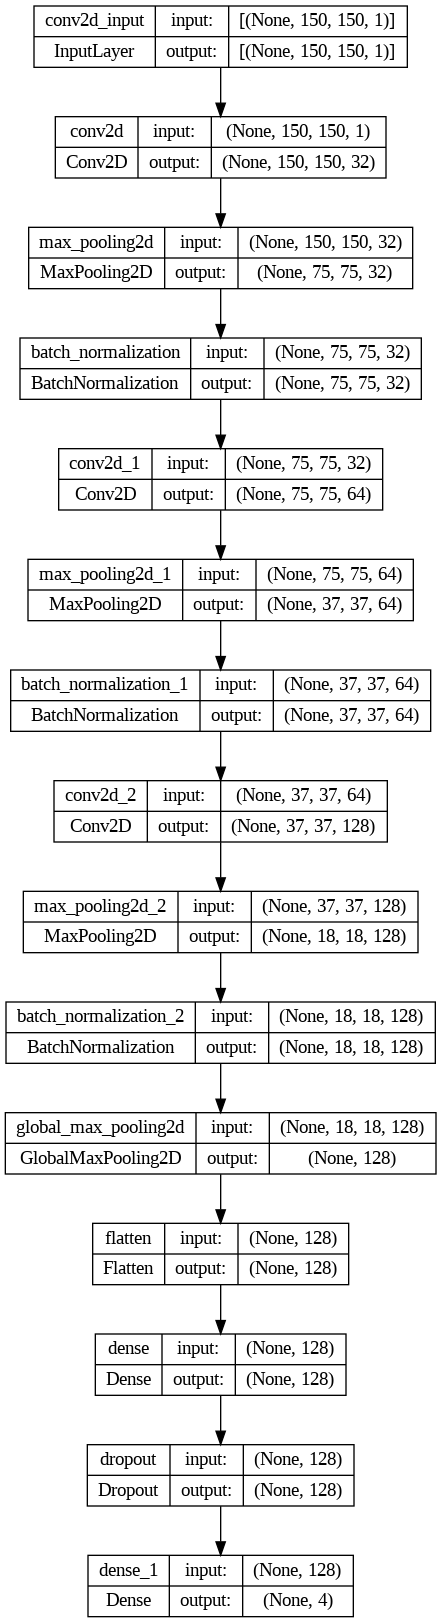

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(b_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(to_categorical(c_breathability), axis=1)
class_weights = compute_class_weight('balanced', classes = np.unique(y_integers), y = y_integers)
d_class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

array([1.18571429, 0.86458333, 2.44117647, 0.62878788])

In [ ]:
d_class_weights

{0: 1.1857142857142857,
 1: 0.8645833333333334,
 2: 2.4411764705882355,
 3: 0.6287878787878788}

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(to_categorical(c_breathability), axis=1)
class_weights = compute_class_weight('balanced', classes = np.unique(y_integers), y = y_integers)
d_class_weights = dict(enumerate(class_weights))
epochs = 1500
batch_size = 8
train_steps = img_train.shape[0] // batch_size
valid_steps = img_test.shape[0] // batch_size
history = b_model.fit(train_gen,
                          steps_per_epoch = train_steps,
                          epochs=epochs,
                          validation_data=test_gen,
                          batch_size = batch_size,
                          class_weight = d_class_weights,
                          callbacks = callbacks()
                          )

Выходные данные были обрезаны до нескольких последних строк (5000).
16/16 [==============================] - 0s 22ms/step - loss: 1.4707 - accuracy: 0.4062 - val_loss: 1.7482 - val_accuracy: 0.2941 - lr: 1.0000e-05
Epoch 149/1500
16/16 [==============================] - ETA: 0s - loss: 1.5070 - accuracy: 0.4274
Epoch 149: val_accuracy did not improve from 0.35294
16/16 [==============================] - 0s 22ms/step - loss: 1.5070 - accuracy: 0.4274 - val_loss: 1.7473 - val_accuracy: 0.2941 - lr: 1.0000e-05
Epoch 150/1500
13/16 [=======================>......] - ETA: 0s - loss: 1.5112 - accuracy: 0.4327
Epoch 150: val_accuracy did not improve from 0.35294
16/16 [==============================] - 0s 22ms/step - loss: 1.4730 - accuracy: 0.4113 - val_loss: 1.7438 - val_accuracy: 0.2941 - lr: 1.0000e-05
Epoch 151/1500
14/16 [=========================>....] - ETA: 0s - loss: 1.5159 - accuracy: 0.3750
Epoch 151: val_accuracy did not improve from 0.35294
16/16 [==============================]

KeyboardInterrupt: ignored

In [ ]:
b_model.load_weights('79ValAcc.h5')

In [ ]:
a = b_model.predict(img_test)
for i in range(len(a)):
  print('Predict:', a[i],"|", "true:", br_test[i])

2/2 [==============================] - 1s 9ms/step
Predict: [0.00505192 0.01286776 0.00499436 0.977086  ] | true: [0. 0. 0. 1.]
Predict: [0.00812343 0.03961335 0.02413366 0.9281295 ] | true: [0. 0. 0. 1.]
Predict: [0.764995   0.21155131 0.00327108 0.02018264] | true: [1. 0. 0. 0.]
Predict: [0.00225598 0.9838664  0.0031982  0.01067946] | true: [0. 1. 0. 0.]
Predict: [1.2524822e-04 1.3742787e-03 8.2736666e-04 9.9767309e-01] | true: [0. 0. 0. 1.]
Predict: [9.9988484e-01 1.0772962e-04 9.6326210e-07 6.3973912e-06] | true: [0. 1. 0. 0.]
Predict: [0.7814767  0.08653254 0.00670667 0.12528405] | true: [0. 1. 0. 0.]
Predict: [0.5265917  0.39965907 0.00949227 0.064257  ] | true: [1. 0. 0. 0.]
Predict: [0.00167413 0.03523002 0.00765434 0.9554415 ] | true: [0. 0. 0. 1.]
Predict: [0.6233138  0.11529818 0.05211462 0.20927344] | true: [1. 0. 0. 0.]
Predict: [0.06285658 0.23537932 0.12806727 0.57369685] | true: [0. 0. 0. 1.]
Predict: [0.10548815 0.31914324 0.16133548 0.41403314] | true: [0. 0. 0. 1.]
P

In [ ]:
print(b_model.evaluate(img_test, br_test))
br_pred = []
a = b_model.predict(img_test)
for i in range(len(a)):
  br_pred.append([np.argmax(a[i])])
  print('Predict:', np.argmax(a[i]),"|", "true:", np.argmax(br_test[i]))

2/2 [==============================] - 8s 93ms/step - loss: 1.3137 - accuracy: 0.8235
[1.3137363195419312, 0.8235294222831726]
2/2 [==============================] - 0s 8ms/step
Predict: 0 | true: 0
Predict: 0 | true: 0
Predict: 3 | true: 3
Predict: 1 | true: 1
Predict: 3 | true: 1
Predict: 1 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 3
Predict: 1 | true: 1
Predict: 0 | true: 0
Predict: 2 | true: 2
Predict: 0 | true: 0
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 1
Predict: 0 | true: 0
Predict: 3 | true: 3
Predict: 0 | true: 0
Predict: 1 | true: 1
Predict: 0 | true: 0
Predict: 0 | true: 0
Predict: 0 | true: 0
Predict: 3 | true: 3
Predict: 0 | true: 0
Predict: 0 | true: 0
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 2 | true: 2
Predict: 3 | true: 1
Predict: 0 | true: 0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(br_test, to_categorical(br_pred)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.40      0.57        10
           2       1.00      1.00      1.00         2
           3       0.62      1.00      0.77        10

   micro avg       0.82      0.82      0.82        34
   macro avg       0.91      0.85      0.84        34
weighted avg       0.89      0.82      0.81        34
 samples avg       0.82      0.82      0.82        34



In [ ]:
print(b_model.evaluate(img_train, br_train))
br_pred_tr = []
a = b_model.predict(img_train)
for i in range(len(a)):
  br_pred_tr.append([np.argmax(a[i])])
  print('Predict:', np.argmax(a[i]),"|", "true:", np.argmax(br_train[i]))

5/5 [==============================] - 0s 14ms/step - loss: 1.4559 - accuracy: 0.7727
[1.455892562866211, 0.7727272510528564]
5/5 [==============================] - 0s 16ms/step
Predict: 1 | true: 0
Predict: 2 | true: 2
Predict: 0 | true: 0
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 0 | true: 0
Predict: 1 | true: 1
Predict: 2 | true: 2
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 2 | true: 2
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 0 | true: 0
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 1
Predict: 1 | true: 1
Predict: 3 | true: 1
Predict: 3 | true: 3
Predict: 2 | true: 2
Predict: 3 | true: 3
Predict: 3 | true: 1
Predict: 3 | true: 1
Predict: 1 | true: 0
Predict: 3 | true: 1
Predict: 3 | true: 3
Predict: 3 | true: 1
Predict: 3 | true: 3
Predict: 3 | true: 3
Predict: 3 | true: 1
Predict: 3 | true: 3
Pre

In [ ]:
print(classification_report(br_train, to_categorical(br_pred_tr)))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90        23
           1       0.79      0.39      0.53        38
           2       1.00      0.93      0.97        15
           3       0.68      0.96      0.79        56

   micro avg       0.77      0.77      0.77       132
   macro avg       0.87      0.78      0.80       132
weighted avg       0.80      0.77      0.76       132
 samples avg       0.77      0.77      0.77       132



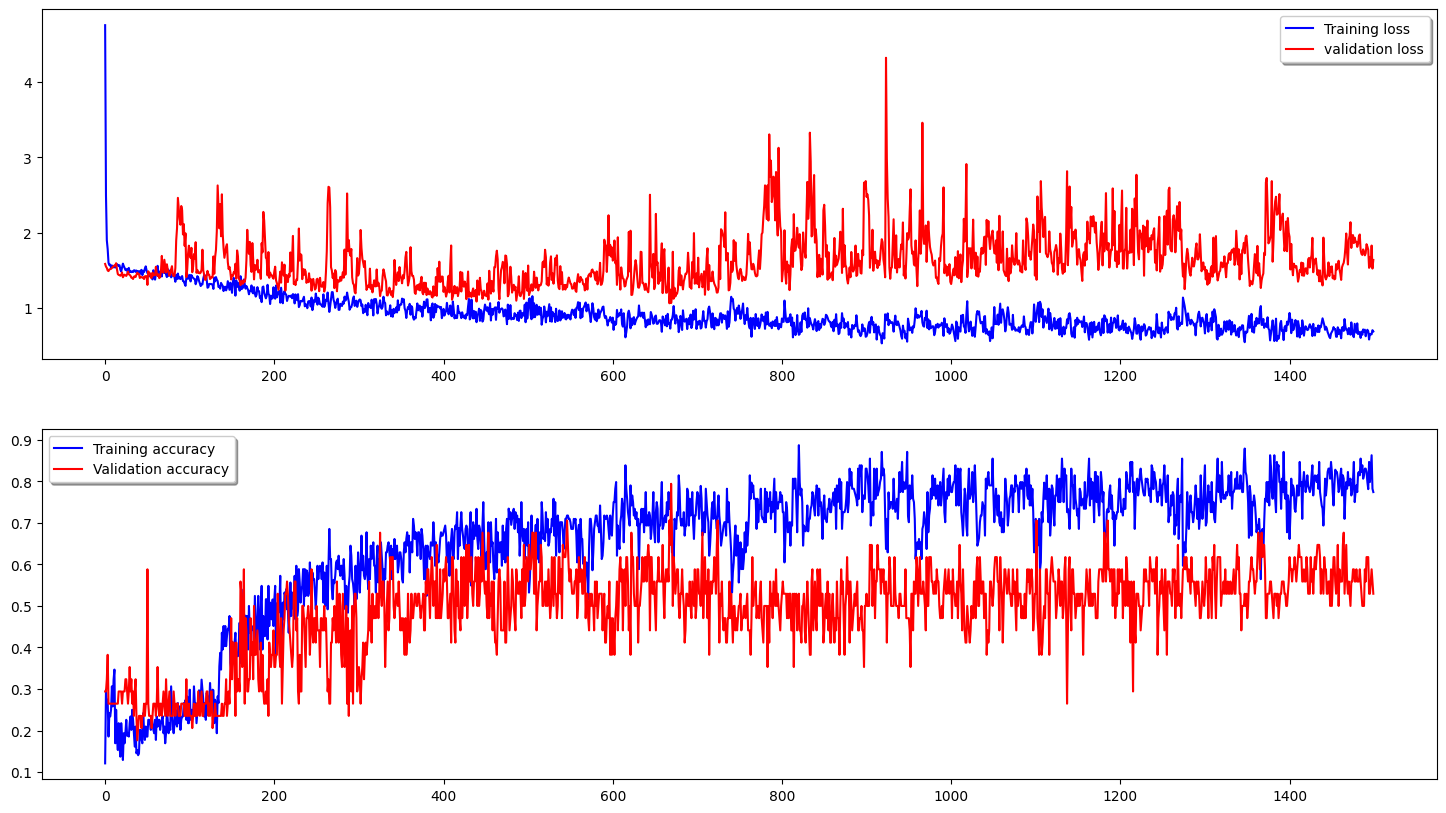

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

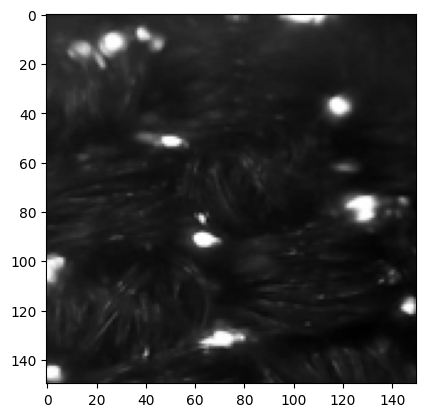

In [ ]:
plt.imshow(test_gen.next()[0][0], cmap="gray")